In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import os
# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [5]:
def load_and_inspect(file_path):
    """
    Loads the embeddings file and performs basic statistical sanity checks.
    """
    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found.")
        return None, None

    data = torch.load(file_path)
    ids = list(data.keys())
    matrix = torch.stack(list(data.values())).numpy()
    
    print(f" Loaded {len(ids)} speakers.")
    print(f" Embedding dimensions: {matrix.shape[1]}")
    
    # Statistical checks
    norms = np.linalg.norm(matrix, axis=1)
    print(f"\n--- Statistics ---")
    print(f"Min Norm: {norms.min():.4f} (Should be ~1.0)")
    print(f"Max Norm: {norms.max():.4f} (Should be ~1.0)")
    print(f"Mean Value: {matrix.mean():.4f}")
    print(f"Std Deviation: {matrix.std():.4f}")
    
    if np.isnan(matrix).any():
        print(" CRITICAL: NaN values detected in embeddings!")
    
    return ids, matrix

# Execution
PT_FILE = r"C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOOF\app\embedding\speaker_embeddings.pt" # Adjust path if necessary
speaker_ids, embeddings_matrix = load_and_inspect(PT_FILE)

 Loaded 162 speakers.
 Embedding dimensions: 512

--- Statistics ---
Min Norm: 1.0000 (Should be ~1.0)
Max Norm: 1.0000 (Should be ~1.0)
Mean Value: -0.0258
Std Deviation: 0.0358


C:\Users\ASUS\AppData\Local\Temp\ipykernel_249252\342325224.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


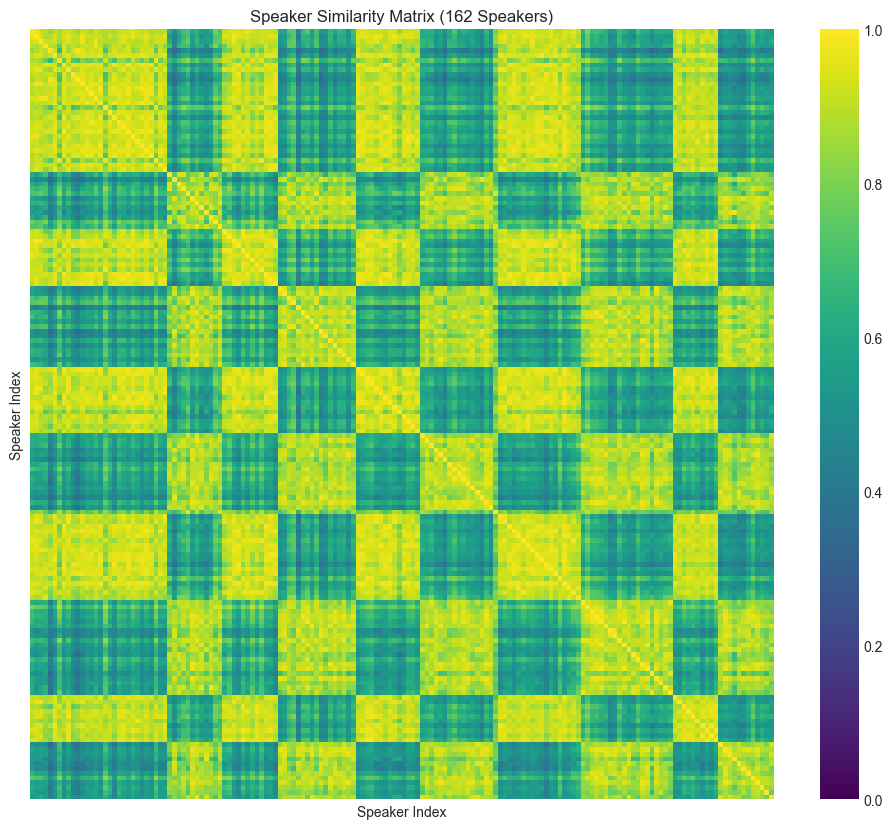

Average Similarity between different speakers: 0.7383
Interpretation: Lower is better. < 0.5 is excellent. > 0.8 implies poor separation.


In [8]:
def plot_similarity_matrix(matrix, ids):
    """
    Plots the cosine similarity matrix between all speakers.
    Diagonal should be 1.0 (yellow/bright).
    Off-diagonal should be lower (blue/dark) indicating distinct voices.
    """
    # Compute Cosine Similarity (Dot product of normalized vectors)
    similarity = np.dot(matrix, matrix.T)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        similarity, 
        cmap="viridis", 
        xticklabels=False, 
        yticklabels=False,
        vmin=0.0, 
        vmax=1.0
    )
    plt.title(f"Speaker Similarity Matrix ({len(ids)} Speakers)")
    plt.xlabel("Speaker Index")
    plt.ylabel("Speaker Index")
    plt.show()
    
    # Calculate average distinction
    # We ignore the diagonal (self-similarity)
    mask = np.ones_like(similarity, dtype=bool)
    np.fill_diagonal(mask, 0)
    avg_sim = similarity[mask].mean()
    
    print(f"Average Similarity between different speakers: {avg_sim:.4f}")
    print("Interpretation: Lower is better. < 0.5 is excellent. > 0.8 implies poor separation.")

if speaker_ids is not None:
    plot_similarity_matrix(embeddings_matrix, speaker_ids)

Computing t-SNE projection (this may take a few seconds)...


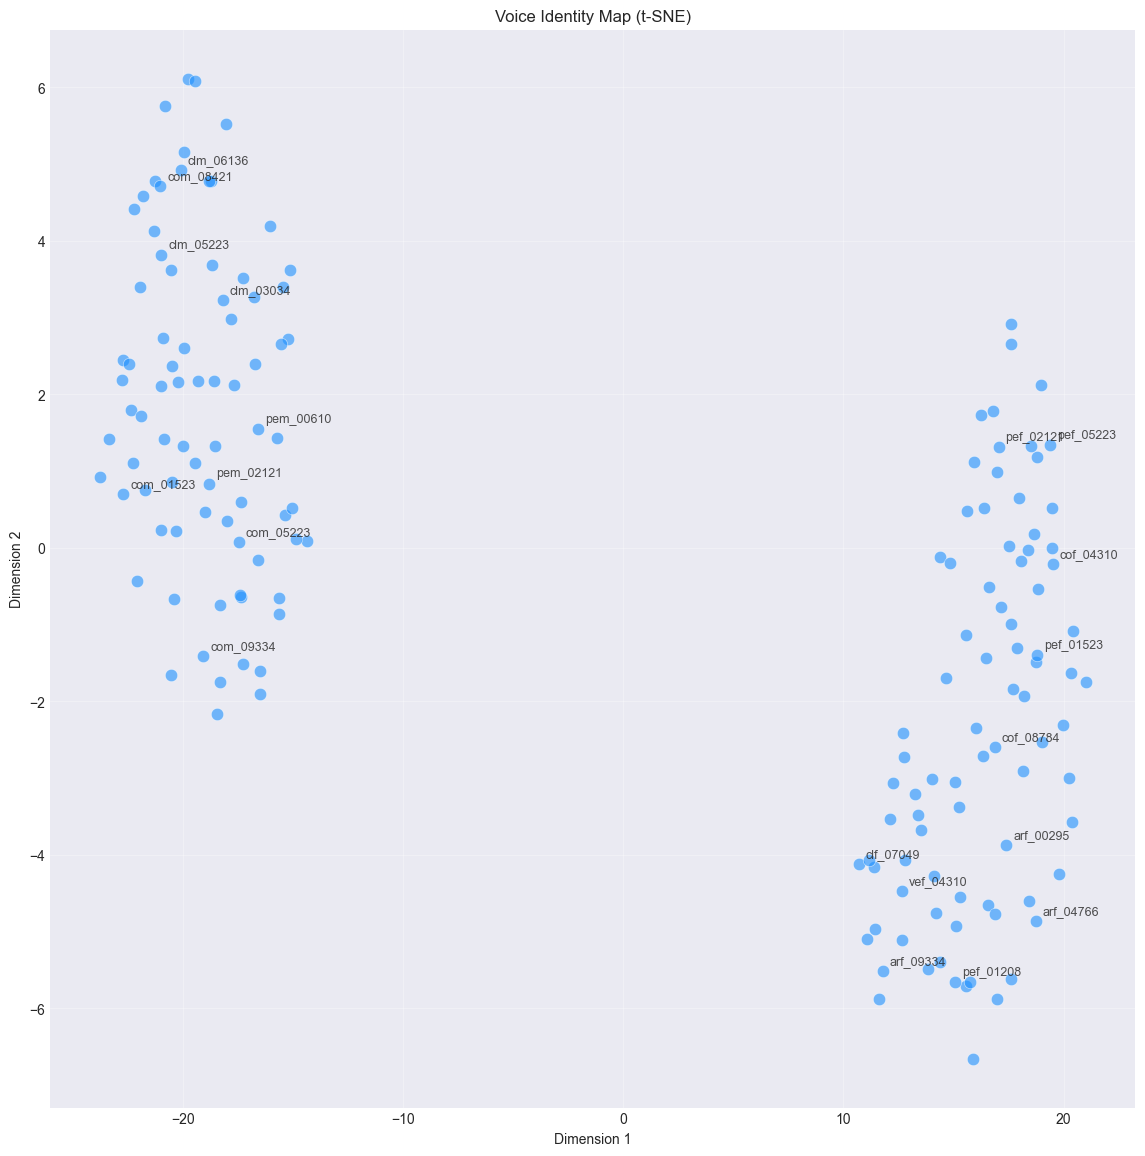

In [7]:
def plot_tsne_projection(matrix, ids):
    """
    Reduces dimensionality using t-SNE to visualize speaker distribution.
    """
    print("Computing t-SNE projection (this may take a few seconds)...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    projections = tsne.fit_transform(matrix)
    
    plt.figure(figsize=(14, 14))
    
    # Scatter plot
    plt.scatter(
        projections[:, 0], 
        projections[:, 1], 
        alpha=0.6, 
        s=80, 
        c='dodgerblue', 
        edgecolor='white', 
        linewidth=0.5
    )
    
    # Annotate a random subset of speakers to avoid clutter
    indices = np.random.choice(len(ids), size=min(20, len(ids)), replace=False)
    for i in indices:
        plt.annotate(
            ids[i], 
            (projections[i, 0], projections[i, 1]),
            xytext=(5, 5), 
            textcoords='offset points',
            fontsize=9,
            alpha=0.8
        )
        
    plt.title("Voice Identity Map (t-SNE)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True, alpha=0.3)
    plt.show()

if speaker_ids is not None:
    plot_tsne_projection(embeddings_matrix, speaker_ids)